In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import datetime
import glob
import itertools
import os
import random
import shutil

import cv2
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import display
from PIL import Image as im
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, precision_score, recall_score)
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import (BatchNormalization, Concatenate, Conv2D,
                                     Conv2DTranspose, Dropout, Input,
                                     MaxPool2D)
from tensorflow.keras.losses import (CategoricalCrossentropy,
                                     SparseCategoricalCrossentropy)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.random.seed(42)
tf.random.set_seed(42)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, matthews_corrcoef


In [4]:
train = '/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/train'
test = '/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/test'
val = '/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/val'
#rescale parameter equal to 1/255 to normalize these values
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,       # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,   # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2,  # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,         # Apply random shear transformations
    zoom_range=0.2,          # Randomly zoom into images
    fill_mode='nearest'      # Fill in newly created pixels during augmentation
)

test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators with augmentation
training_set = train_datagen.flow_from_directory(
    directory=train,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle= True,
)

test_set = test_datagen.flow_from_directory(
    directory=test,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle= False,
)

val_set = val_datagen.flow_from_directory(
    directory=val,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle= False,
)

Found 18400 images belonging to 8 classes.
Found 2800 images belonging to 8 classes.
Found 2800 images belonging to 8 classes.


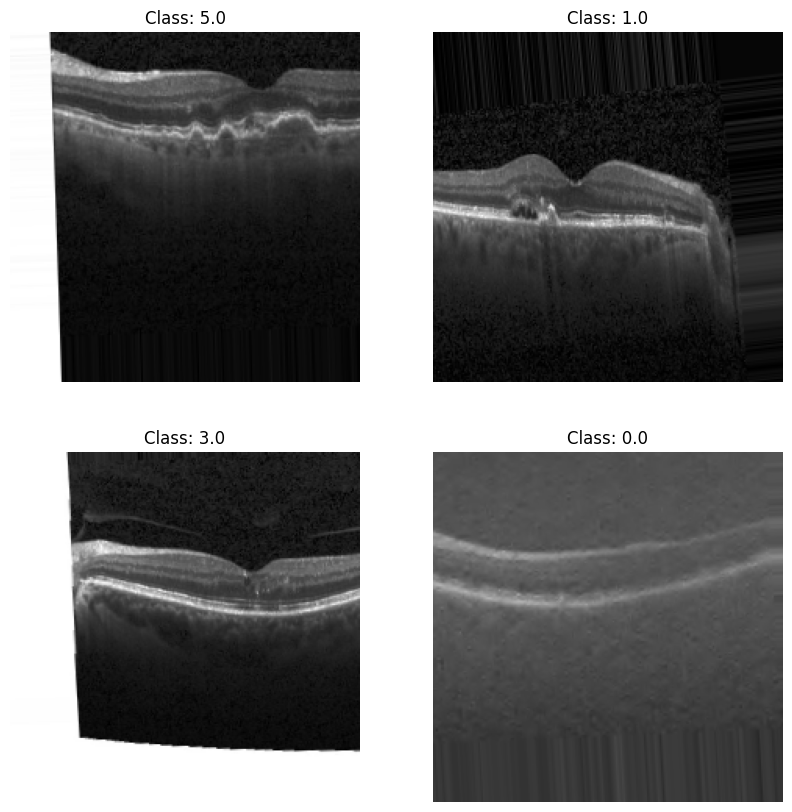

In [5]:
import matplotlib.pyplot as plt

# Get a batch of images from the training data generator
batch_images, batch_labels = training_set.next()

# Plot four samples
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(batch_images[i])
    plt.title(f"Class: {batch_labels[i]}")
    plt.axis("off")

plt.show()

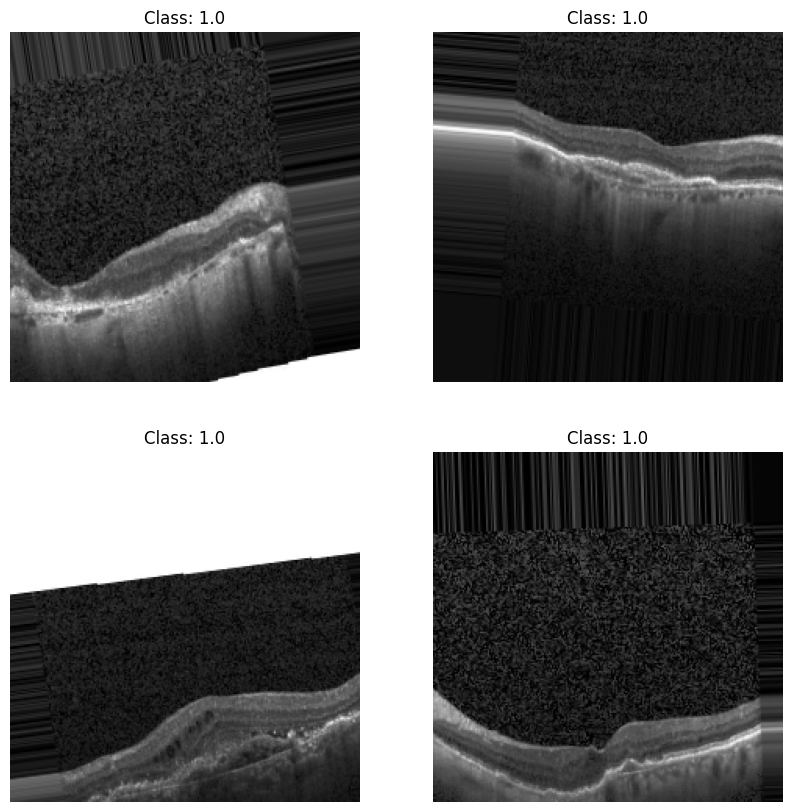

In [6]:
import matplotlib.pyplot as plt

# Get a batch of images from the training data generator
batch_images, batch_labels = training_set.next()

# Plot four samples
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(batch_images[i])
    plt.title(f"Class: {batch_labels[i]}")
    plt.axis("off")

plt.show()

In [7]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [8]:
num_classes=8

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, ReLU, Dropout, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model

def cbam_block(x, channels, reduction_ratio=16):
    # Spatial attention
    spatial_avg = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
    spatial_max = tf.reduce_max(x, axis=[1, 2], keepdims=True)
    spatial_attention = tf.keras.layers.Conv2D(channels // reduction_ratio, kernel_size=1, strides=1, padding='same')(spatial_avg)
    spatial_attention = tf.keras.layers.ReLU()(spatial_attention)
    spatial_attention = tf.keras.layers.Conv2D(channels, kernel_size=1, strides=1, padding='same')(spatial_attention)
    spatial_attention = tf.keras.layers.Activation('sigmoid')(spatial_attention)

    # Channel attention
    channel_avg = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
    channel_max = tf.reduce_max(x, axis=[1, 2], keepdims=True)
    channel_attention = tf.keras.layers.Conv2D(channels // reduction_ratio, kernel_size=1, strides=1, padding='same')(channel_avg)
    channel_attention = tf.keras.layers.ReLU()(channel_attention)
    channel_attention = tf.keras.layers.Conv2D(channels, kernel_size=1, strides=1, padding='same')(channel_attention)
    channel_attention = tf.keras.layers.Activation('sigmoid')(channel_attention)

    # Apply attention
    x = x * spatial_attention + x * channel_attention
    return x

input_shape = (224, 224, 3)
input_tensor = Input(shape=input_shape)

num_classes = 8  # Specify the number of classes in your dataset

base_model = VGG16(include_top=False, input_tensor=input_tensor, weights='imagenet')
x = base_model.output

# First CBAM-enhanced convolution block
x1 = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x1 = cbam_block(x1, 256)

# Second CBAM-enhanced convolution block with skip connection from x1
x2 = Conv2D(256, (3, 3), padding='same', activation='relu')(x1)
x2 = cbam_block(x2, 256)
x2 = Concatenate()([x1, x2])  # Skip connection by concatenation

# Third CBAM-enhanced convolution block with skip connection from x2
x3 = Conv2D(256, (3, 3), padding='same', activation='relu')(x2)
x3 = cbam_block(x3, 256)
x3 = Concatenate()([x2, x3])  # Another skip connection by concatenation

x = GlobalAveragePooling2D()(x3)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=x)


model = Model(inputs=input_tensor, outputs=x)

from tensorflow.keras.optimizers.schedules import CosineDecay

initial_learning_rate = 0.01
decay_steps = 1000
alpha = 0.0001  # Final learning rate

lr_schedule = CosineDecay(initial_learning_rate, decay_steps, alpha=alpha)

sgd_optimizer = SGD(learning_rate=lr_schedule, momentum=0.9)

model.compile(optimizer=sgd_optimizer, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])
model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                           

In [10]:
from keras.optimizers import Adam, SGD

In [11]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Dense, Flatten, ReLU,Dropout
# from tensorflow.keras.applications import VGG19,ResNet50
# def cbam_block(x, channels, reduction_ratio=16):
#     # Spatial attention
#     spatial_avg = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
#     spatial_max = tf.reduce_max(x, axis=[1, 2], keepdims=True)
#     spatial_attention = tf.keras.layers.Conv2D(channels // reduction_ratio, kernel_size=1, strides=1, padding='same')(spatial_avg)
#     spatial_attention = tf.keras.layers.ReLU()(spatial_attention)
#     spatial_attention = tf.keras.layers.Conv2D(channels, kernel_size=1, strides=1, padding='same')(spatial_attention)
#     spatial_attention = tf.keras.layers.Activation('sigmoid')(spatial_attention)

#     # Channel attention
#     channel_avg = tf.reduce_mean(x, axis=[1, 2], keepdims=True)  # Change from [3] to [1, 2]
#     channel_max = tf.reduce_max(x, axis=[1, 2], keepdims=True)  # Change from [3] to [1, 2]
#     channel_attention = tf.keras.layers.Conv2D(channels // reduction_ratio, kernel_size=1, strides=1, padding='same')(channel_avg)
#     channel_attention = tf.keras.layers.ReLU()(channel_attention)
#     channel_attention = tf.keras.layers.Conv2D(channels, kernel_size=1, strides=1, padding='same')(channel_attention)
#     channel_attention = tf.keras.layers.Activation('sigmoid')(channel_attention)

#     # Apply attention
#     x = x * spatial_attention + x * channel_attention

#     return x

# input_shape = (224, 224, 3)

# Vgg = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# # CBAM VGG19
# ratio = 16

# input_layer = Input(shape=input_shape)
# out = Vgg.layers[1](input_layer)  # Block one of VGG19
# out = Vgg.layers[2](out)
# out = Vgg.layers[3](out)
# out = cbam_block(out, channels=out.shape[-1], reduction_ratio=ratio)
# out = Vgg.layers[4](out)  # Block two of VGG19
# out = Vgg.layers[5](out)
# out = Vgg.layers[6](out)

# out = cbam_block(out, channels=out.shape[-1], reduction_ratio=ratio)
# out = Vgg.layers[7](out)  # Block three of VGG19
# out = Vgg.layers[8](out)
# out = Vgg.layers[9](out)
# out = cbam_block(out, channels=out.shape[-1], reduction_ratio=ratio)
# out = Vgg.layers[10](out)
# out = Vgg.layers[11](out)
# out = Vgg.layers[12](out)  # Block four of VGG19
# out = cbam_block(out, channels=out.shape[-1], reduction_ratio=ratio)
# out = Vgg.layers[13](out)
# #out = cbam_block(out, channels=out.shape[-1], reduction_ratio=ratio)
# out = Vgg.layers[14](out)
# out = cbam_block(out, channels=out.shape[-1], reduction_ratio=ratio)
# out = Vgg.layers[15](out)
# #out = cbam_block(out, channels=out.shape[-1], reduction_ratio=ratio)
# out = Vgg.layers[16](out)

# #out = cbam_block(out, channels=out.shape[-1], reduction_ratio=ratio)
# out = Vgg.layers[17](out)  # Block five of VGG19
# out = cbam_block(out, channels=out.shape[-1], reduction_ratio=ratio)
# out = Vgg.layers[18](out)
# #out = cbam_block(out, channels=out.shape[-1], reduction_ratio=ratio)
# out = Vgg.layers[19](out)
# out = Vgg.layers[20](out)
# out = cbam_block(out, channels=out.shape[-1], reduction_ratio=ratio)
# #out = cbam_block(out, channels=out.shape[-1], reduction_ratio=ratio)
# out = Vgg.layers[21](out)

# #out = cbam_block(out, channels=out.shape[-1], reduction_ratio=ratio)
# flatten = Flatten()(out)
# out = Dense(100)(flatten)
# out = Dropout(0.5)(out) 
# out = ReLU()(out)

# out = Dense(100)(out)
# out = Dropout(0.5)(out) 
# out = ReLU()(out)
# out = Dense(8)(out)
# out = tf.keras.layers.Softmax()(out)

# model = Model(input_layer, out)
# # Set initial learning rate for Adam
# initial_lr_adam = 0.0001
# adam_optimizer1 = Adam(learning_rate=initial_lr_adam)
# opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.001)
# # Set learning rate for SGD
lr_sgd = 0.0001
sgd_optimizer = SGD(learning_rate=lr_sgd)

# #------
# initial_learning_rate = 0.01
# first_decay_steps = 1000
# lr_decayed_fn = (
#   tf.keras.optimizers.schedules.CosineDecayRestarts(
#       initial_learning_rate,
#       first_decay_steps))
# sgd_optimizer2 = SGD(learning_rate=lr_decayed_fn)
# # Compile the model with the Adam optimizer
model.compile(optimizer=sgd_optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

In [12]:
from keras import backend as K

history = model.fit(
    x=training_set,  
    validation_data= val_set, 
    epochs=50
)


Epoch 1/50
575/575 [==============================] - 404s 681ms/step - loss: 2.0968 - accuracy: 0.1270 - val_loss: 2.0632 - val_accuracy: 0.2050
Epoch 2/50
575/575 [==============================] - 259s 450ms/step - loss: 2.0715 - accuracy: 0.1531 - val_loss: 2.0410 - val_accuracy: 0.2454
Epoch 3/50
575/575 [==============================] - 259s 450ms/step - loss: 2.0505 - accuracy: 0.1866 - val_loss: 2.0059 - val_accuracy: 0.3421
Epoch 4/50
575/575 [==============================] - 259s 451ms/step - loss: 2.0131 - accuracy: 0.2302 - val_loss: 1.9307 - val_accuracy: 0.4132
Epoch 5/50
575/575 [==============================] - 261s 454ms/step - loss: 1.9212 - accuracy: 0.2871 - val_loss: 1.7283 - val_accuracy: 0.4268
Epoch 6/50
575/575 [==============================] - 251s 435ms/step - loss: 1.6970 - accuracy: 0.3498 - val_loss: 1.3480 - val_accuracy: 0.4743
Epoch 7/50
575/575 [==============================] - 253s 439ms/step - loss: 1.4036 - accuracy: 0.4127 - val_loss: 1.1570 -

Text(0.5, 1.0, 'Accuracy Curves')

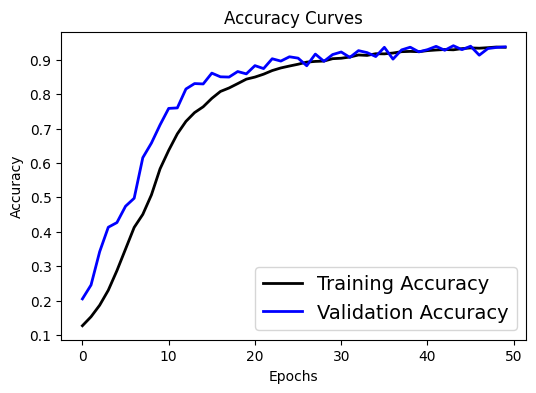

In [13]:
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

Text(0.5, 1.0, 'Loss Curves')

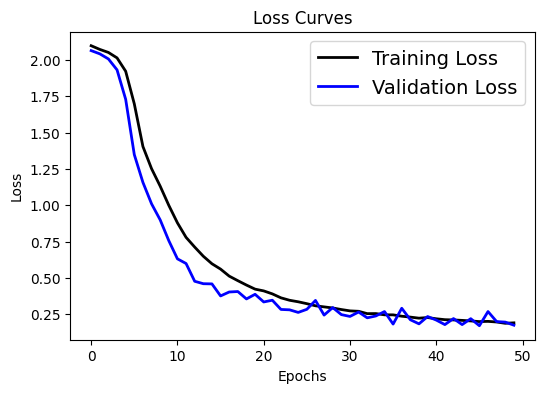

In [14]:
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

In [15]:

import numpy as np
from sklearn.metrics import classification_report

# Get predictions
validation_steps_per_epoch = np.math.ceil(val_set.samples / val_set.batch_size)
predictions = model.predict_generator(val_set, steps=validation_steps_per_epoch)

# Get the most likely class
predicted_classes = np.argmax(predictions, axis=1)

# Get the true classes
true_classes = val_set.classes

# Get the class labels
class_labels = list(val_set.class_indices.keys())

# Print the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

/tmp/ipykernel_26/1713122531.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(val_set, steps=validation_steps_per_epoch)


              precision    recall  f1-score   support

         AMD       1.00      0.99      1.00       350
         CNV       0.98      0.86      0.91       350
         CSR       0.99      1.00      1.00       350
         DME       0.94      0.82      0.87       350
          DR       1.00      0.99      0.99       350
      DRUSEN       0.85      0.87      0.86       350
          MH       1.00      1.00      1.00       350
      NORMAL       0.79      0.97      0.87       350

    accuracy                           0.94      2800
   macro avg       0.94      0.94      0.94      2800
weighted avg       0.94      0.94      0.94      2800



In [16]:
import seaborn as sns

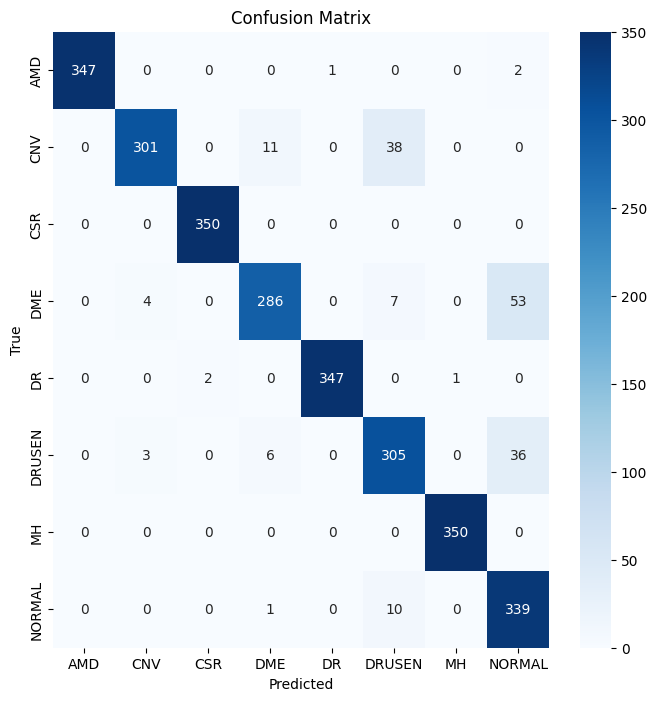

In [17]:
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_mat = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(len(class_labels), len(class_labels)))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('/kaggle/working/confusion_matrix.png', dpi=1000)  # Save the figure in high resolution
plt.show()



In [18]:
# def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
#     plt.figure(figsize= (10, 10))
#     plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation= 45)
#     plt.yticks(tick_marks, classes)
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
#         print('Normalized Confusion Matrix')
#     else:
#         print('Confusion Matrix, Without Normalization')
#     print(cm)
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
#     plt.tight_layout()
#     plt.ylabel('True Label')
#     plt.xlabel('Predicted Label')
    

In [19]:
# preds = model.predict_generator(test_set)
# y_pred = np.argmax(preds, axis=1)
    

In [20]:
# target_names = ['AMD', 'CNV', 'CSR', 'DME', 'DR', 'DRUSEN', 'MH', 'Normal']
# # Confusion matrix
# cm = confusion_matrix(test_set.classes, y_pred)
# plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# # Classification report
# print(classification_report(test_set.classes, y_pred, target_names= target_names))

In [21]:
acc, loss = model.evaluate(test_set, verbose = 1) 
print('test loss = ', loss)
print('test accuracy = ',acc)

88/88 [==============================] - 29s 330ms/step - loss: 0.1679 - accuracy: 0.9436
test loss =  0.9435714483261108
test accuracy =  0.16789209842681885


In [22]:
# Save the model in Kaggle's working directory
model.save('/kaggle/working/my_model.h5')  # Saves the model for later use or download

# Convert the history.history dict to a pandas DataFrame: Contains metrics collected during training
hist_df = pd.DataFrame(history.history)

# Save the history data to CSV in Kaggle's working directory
hist_df.to_csv('/kaggle/working/training_history.csv', index=False)

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
